# DRIVE FOR SHOW, PUTT FOR DOUGH?
# Andre Chan

### We analyse PGA Tour data from 27 tournaments in the 2020-21 season, focusing on Driving & Putting.

### Objectives 
1. Build statistical models to gain insights into *PGA Tour* players' **Driving (on Par 5s)** and **Putting**. <br>
2. ***'Drive for Show, Putt for Dough'*** - feel or real?

# Preliminaries

Our data is collected from **654k shots** from **401 players** in the (ongoing) PGA Tour 2020-21 season. 

In [1]:
from pga_analysis.strokes_gained import *; from pga_analysis.par_5_tee_shots import *; from pga_analysis.putting import *; from pga_analysis.golf_stats import *; from pga_analysis.helpers import *;

In [2]:
pga_data = pd.read_csv(r'data/pga_tour_shot_level_data.csv', encoding='cp1252'); pga_data.head()

,player,round_number,hole_number,hole_par,hole_yards,tournament,shot_number,shot_end_distance_yards,shot_start_distance_yards,shot_end_location,shot_start_location
0,Aaron Baddeley,1,1,4,407yds,2020_3m_open,1,162.000000,407.000000,left fairway,tee
1,Aaron Baddeley,1,1,4,407yds,2020_3m_open,2,6.166667,162.000000,green,left fairway
2,Aaron Baddeley,1,1,4,407yds,2020_3m_open,3,0.138889,6.166667,green,green
3,Aaron Baddeley,1,1,4,407yds,2020_3m_open,4,0.000000,0.138889,in the hole,green
4,Aaron Baddeley,1,2,4,450yds,2020_3m_open,1,156.000000,450.000000,left fairway,tee


We begin by preparing the data for analysis and adding useful golf-related statistics:

In [3]:
pga_data['gir'] = compute_gir(pga_data)  # Whether green was hit in regulation.
pga_data['fir'] = compute_fir(pga_data)  # Whether fairway was hit in regulation.
pga_data['strokes_from_here'] = compute_strokes_from_here(pga_data) # Number of strokes from location to complete hole.
pga_data['total_strokes'] = compute_total_strokes(pga_data)  # Total strokes to complete hole.
pga_data['hole_yards'] = hole_yards_to_float(pga_data)  # Convert `hole_yards` column to a number.
pga_data['shot_end_location_simplified'] = pga_data['shot_end_location'].apply(simplify_shot_end_location) # Tidying

# Driving on Par 5s

How does **distance to the pin** following the tee shot affect scores?<br>
How much better is it if a drive ends up in the **fairway compared to the rough**?<br>

### Exploration: Distance to Pin after Tee Shot

On a Par 5, the **average distance to the pin** (DTP) after the tee shot is **258 yards**.

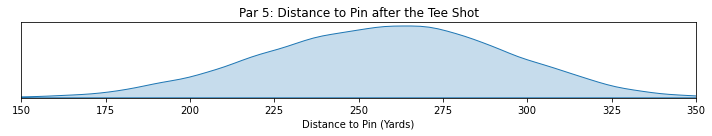

In [4]:
par_5_tee_shot_features = get_par_5_analysis_data(pga_data)
ax = plot_distance_to_pin_distribution(par_5_tee_shot_features)

#### After the Tee Shot, the further the ball from the pin, the more strokes are predicted to hole-out.

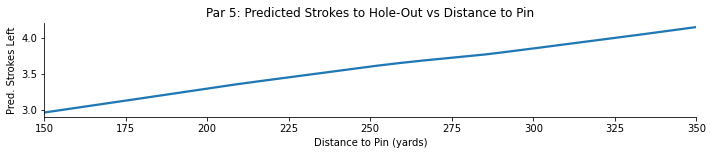

In [5]:
plot_strokes_from_par_5_tee_shot(par_5_tee_shot_features)

### Goal: Predict # strokes to hole-out after the tee shot, given *distance to pin* AND *the ball's finish location*.

We use **linear regression**, since:
- The plot shows a **linear relationship** between DTP and strokes to hole-out.
- We can **interpret** the independent effects of the ball's location and DTP.

In [6]:
# Train linear regression model, predicting strokes to hole-out against DTP & ball location.
strokes_model, coefficients = model_strokes_to_finish_from_par_5_tee_shot(par_5_tee_shot_features)

### Analysis: Ball Location

Inspecting the model's `coefficients`, **for a fixed distance to the pin**:

|      Ball Location     	| Strokes Lost compared to Fairway 	|
|:----------------------:	|:--------------------------------:	|
| **Intermediate Rough** 	|               0.112              	|
|    **Primary Rough**   	|               0.247              	|
|   **Fairway Bunker**   	|               0.363              	|
|        **Dirt**        	|               0.391              	|
|     **Native Area**    	|               0.609              	|
|        **Trees**       	|               0.637              	|
|        **Water**       	|               1.440              	|

### Analysis: Each yard nearer the pin saves a predicted 0.005 strokes.

On a championship course with 4 Par 5's, consistently driving the ball 20 yards nearer the flag saves a predicted **0.4 strokes**.

## But do BIG DRIVES always find the fairways?

*Nope.*

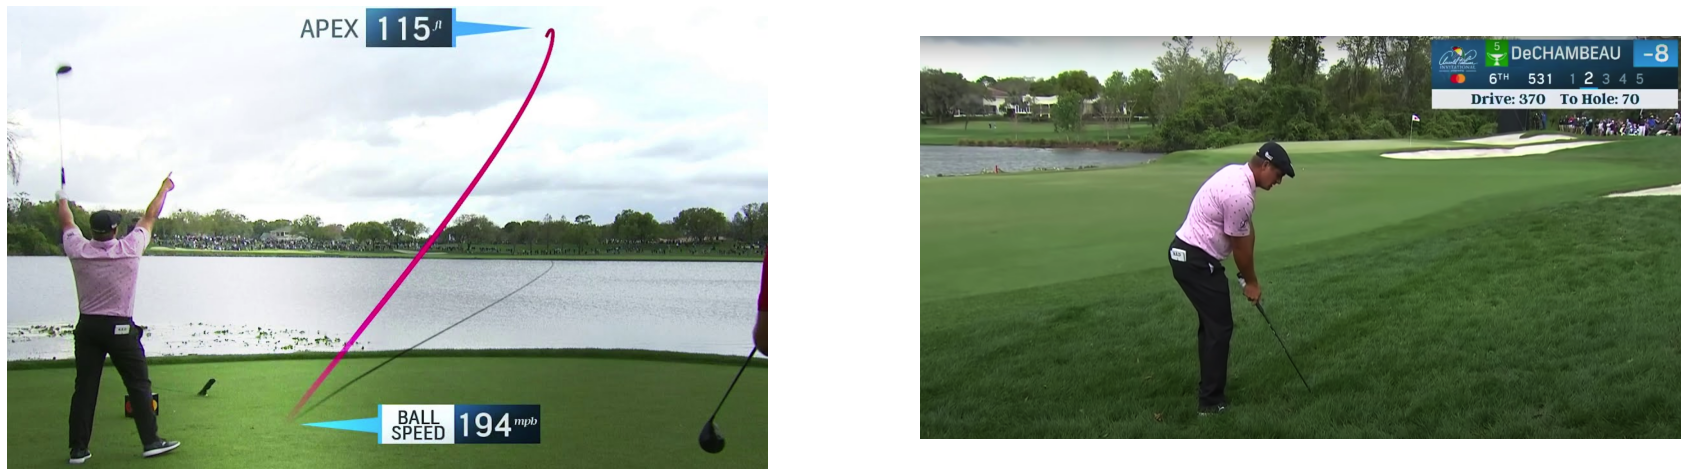

In [7]:
plot_bryson_drive()

# Scraping PGA Tour Data

To find out, I scraped data from the **PGA Tour website** for the **average driving distance** (and **winnings**) for each tournament.

<img src="images/web_scraper.gif" width="750" align="center">

- To control the browser, I used WebDriver for Google Chrome from the Selenium package in Python.
- To scrape the data from each webpage, I used a Selector from the Scrapy package in Python.

In [8]:
pga_data_added = add_scraped_data(pga_data)

## Fairways in Regulation vs Driving Distance

There is a statistically significant **negative** correlation (-0.11) between % fairways hit in regulation and average driving distance on Par 5s.

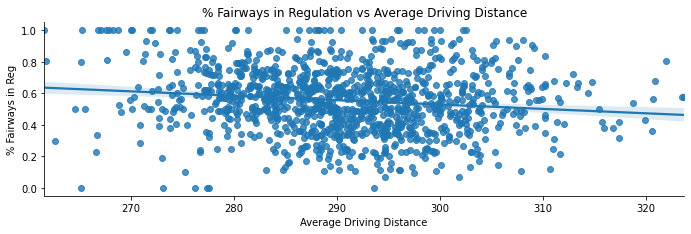

In [9]:
plot_fir_against_driving_distance(pga_data_added)

# Then, which players are the best drivers?

For each player, after the tee shot, we compute their average Distance to Pin and the rate of occurrence of each ball location.

For example, for Bryson DeChambeau over all tournaments,

|           	| Bryson DeChambeau 	|  PGA Tour Average
|:----------------------:	|:--------------------------------:	|:--------------------------------:|
| **Distance to Pin** 	|               228 yards             	| 258 yards |
| **Fairway** 	|               0.591              	| 0.558 |
|    **Primary Rough**   	|               0.255              	| 0.266 |
| **Intermediate Rough** 	|               0.036              	| 0.058 |
|   **Fairway Bunker**   	|               0.036              	| 0.057 |
|     **Native Area**    	|               0.029              	| 0.020 |
|        **Trees**       	|               0.015              	| 0.009 |
|        **Water**       	|               0.015              	| 0.010 |
|        **Dirt**        	|               0.007              	| 0.011 |

Our model then **predicts the average number of strokes to hole-out, after the tee shot**.<br>
The PGA Tour average is **3.652 strokes**.

In [10]:
predicted_strokes_to_finish_par_5_player = rank_players_by_strokes_to_finish_from_par_5_tee_shot(par_5_tee_shot_features, strokes_model)
present_par_5_tee_shot_ranking(predicted_strokes_to_finish_par_5_player)

,Predicted Strokes to Hole-Out after Tee Shot,Rank
"David Berganio, Jr.",3.476,9
Bryson DeChambeau,3.491,10
Nick Hardy,3.496,11


Our model predicts that Bryson DeChambeau is **10th best** (out of 401 players) from the tee on Par 5s.

## But why?

As the model is linear, we can attribute how many strokes are saved **to each variable**, compared to the PGA Tour average.

|           	| Bryson DeChambeau 	| PGA Tour Average |   Strokes Saved vs PGA Tour Average
|:----------------------:	|:--------------------------------:	|:--------------------------------:|:--------------------------------:|
| **Distance to Pin** 	|               228 yards           | 258 yards 	| 0.141 |
| **Fairway** 	|               0.591             | 0.558	| 0.010 |
|    **Primary Rough**   	|               0.255         | 0.266    	| 0.001 |


**Bryson saves most of his strokes due to being able to drive closer to the pin**, <br>rather than because he hits more fairways or fewer roughs (than the average PGA Tour statistics).

### Comments

- `Distance to Pin` after the tee shot is not a fair performance metric, as Par 5s vary in length (std deviation: 31 yards)
    - A fairer metric (used by PGA Tour) could be the ***proportion of yardage covered by the tee shot***.
    
    
- Our model assumes that being closer to the pin is always better, **regardless of resulting ball position**.
    - Add **interaction effects** between DTP and ball position to the model.
        - e.g. being nearer the pin but in the trees should lead to strokes lost (not gained).
        

- This ***strokes gained*** analysis is easily repeated for other types of shots (putting, bunker shots), which can highlight to players where to focus on.

# Putting

<img src="images/bryson_putt_fail.gif" width="749" align="center">

### Goal: Predict **number of putts**, given ball's **distance to the pin**

We use **local regression** models, as we want to predict # putts from ***ANY*** distance to the pin.

- Our model's prediction is the **average # putts from a 0.5-foot radius** of the distance to pin.


- If there were no putts within 0.5 feet of the prediction location in the data, then average the 10 putts closest to it.

### Exploration: # Putts vs Distance to Pin

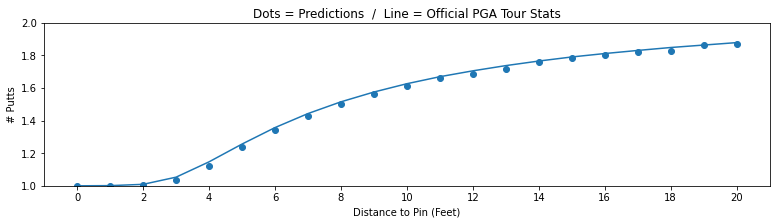

In [11]:
putting_data, first_shot_to_green = prepare_putting_data(pga_data)
plot_number_of_putts_by_yardage(putting_data)

### Strokes Gained

Similarly to Driving on Par 5s, we measure the **strokes gained** for each putt.

**Strokes gained** is the difference between the **predicted # putts from the DTP** and the **actual # putts taken**.<br>
We compute it once on each hole **from when the ball is on the green**.

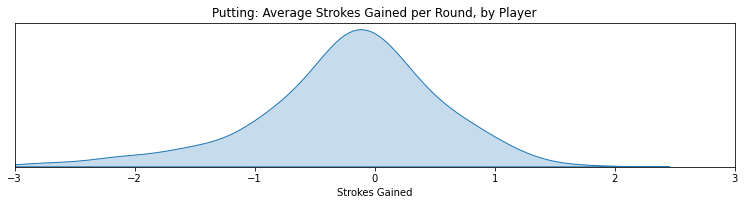

In [12]:
first_shot_to_green['strokes_gained'] = compute_putting_strokes_gained(putting_data, first_shot_to_green)
plot_putting_strokes_gained_distribution(first_shot_to_green)

### Analysis: Good Lag Putting = Good at Holing Out?

There is a weak **positive** correlation (0.06, p-value: 0.24) between a player's SG on putts **over 15 feet** vs **under 15 feet**.

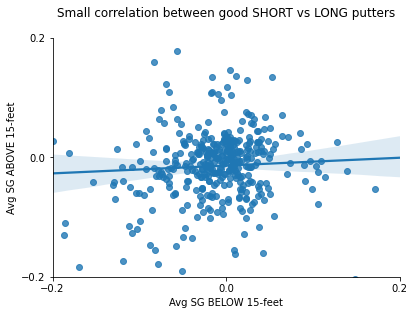

In [13]:
plot_strokes_gained_above_or_below_15_feet(putting_data, first_shot_to_green)

### Then what should I practice?  Analyse your Putts Curve..

Tommy Gainey **loses** many strokes below 10 feet, but **gains** strokes above 10 feet. <br>
*Maybe he should practice his 5-footers..*

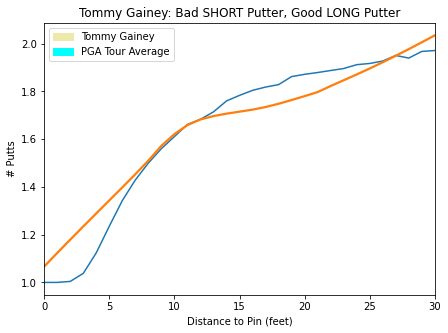

In [14]:
plot_tommy_gainey_putts_curve(first_shot_to_green, putting_data)

# Drive for Show, Putt for Dough?

### In the biggest tournaments, **PUTTING** has a wider spread in total strokes gained than **DRIVING**..

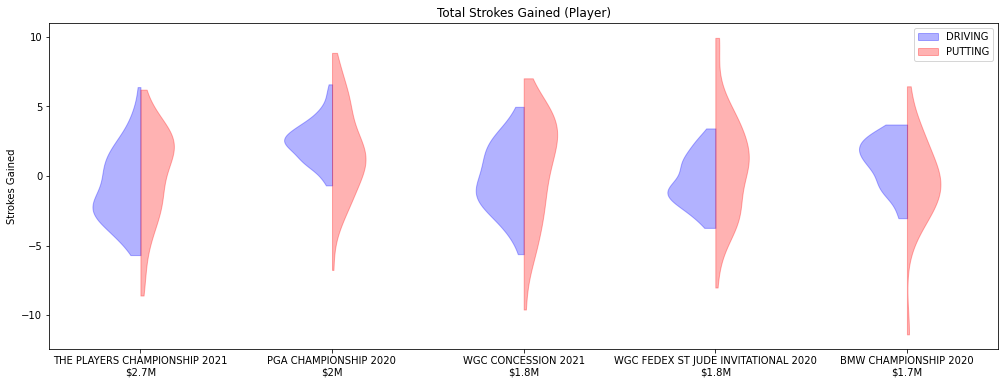

In [15]:
plot_strokes_gained_driving_vs_putting_by_winnings(putting_data, strokes_model,
                                                   par_5_tee_shot_features, pga_data_added, 0, 5)

## But overall?

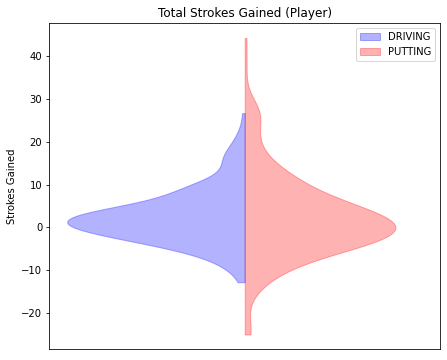

In [16]:
plot_strokes_gained_driving_vs_putting_by_winnings(putting_data, strokes_model,
                                                   par_5_tee_shot_features, pga_data_added, over_all_tournaments=True)

## Maybe Putting wins - but only just...

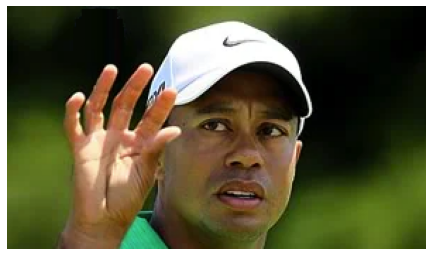

In [17]:
tiger_woods_____only_just()

# With more time..

### Bunker shots
- Are shots near the **front of a bunker (nearer its lip) harder** than those further back?
- How much more likely is a ***sand save*** with more green to work with (more distance to the pin)?

*Possible techniques:* 
- *Linear regression with mixed effects: to model strokes lost, given bunker location and distance to pin*
- *Chi-squared test or ANOVA: to analyse interacting effects,*
    - *e.g. front of bunker with little green to work with*

### Approach shots
- For what distance from the green (and hazards etc) is it **optimal to lay-up instead of attacking the green**?
    - Based on **the player's data**, compare strokes gained from:
        - **Laying up:**
            - The lay-up shot
            - The approach shot after laying up
            - Putts with ~shorter DTP on the green
        - **Attacking the green:**
            - The approach shot and possible hazards (water, bunkers)
            - Lag putts with ~longer DTP on the green
            
    - A **hole-level analysis** might analyse all past outcomes from all players of either shot choice, conditional on the player's abilities
        - Or adjust for course's **slope rating** or average Tour score